## Week 2
### Model quality and decision making. Increment based threshold decisions

In this jupyter-notebook we will learn how to apply increment based threshold decisions

#### Import libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score as f1

import matplotlib.colors
import random



sns.set(style="white")

np.random.seed(2020)

#settings for plots
plt.rcParams.update({'font.size': 16,
                     'xtick.labelsize' : 14, 
                     'ytick.labelsize' : 14,
                     'axes.labelsize' : 16,
                     'axes.titlesize' : 20})

In [2]:
import warnings
warnings.filterwarnings("ignore")

Define some functions that will help us to plot graphs. 

In [3]:
def roc_auc_plot(model, X_train, y_train,
                X_oos, y_oos):
    
    plt.figure(figsize=(12,10))
    colors = ['olivedrab','salmon']
    for it, i in enumerate(['train', 'oos']):
        
        #choose the data
        if i == 'train':
            X = X_train
            y_ = y_train
        else:
            X = X_oos
            y_ = y_oos
        
        y_hat = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y_, y_hat)
        gini = 2 * roc_auc_score(y_, y_hat) - 1
        plt.plot(fpr, tpr, label = i, color = colors[it], linewidth=2)
        print('Model',i, 'gini: ', np.round(gini,2))

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Model old')
    plt.legend(bbox_to_anchor=(1, 1));
    plt.plot([0,1], [0,1], '--', color='grey', label='Random model')

    plt.grid()
    _ = plt.legend(loc= 0, prop= {'size': 16})

In [4]:
def benefit_plot(model, X_train, y_train,
                X_oos, y_oos):
                 
    plt.figure(figsize=(12,8))

    colors = ['olivedrab','salmon']
    
    max_val = []
    for it, i in enumerate(['train', 'oos']):

        if i == 'train':
            X = X_train
            y_ = y_train
        elif i == 'oos':
            X = X_oos
            y_ = y_oos

        val = []    
        ar = []
        
        
        y_ar = X['delta_p']
        
        #y = model.predict_proba(X.drop(columns = ['pred','pred_comm0', 'pred_comm1', 'delta_p']))[:, 1]
        y = X['delta_p']
        
        for t in tqdm_notebook(thr[::-1]):
            X['npv'] = (X.delta_p >= t) * (X.pred_comm1 * e_fp - e_fn) + \
                        (X.delta_p < t) * X.pred_comm0 * e_fp
            
            val.append(X['npv'].mean())
            ar.append((np.sum((X.delta_p >= t)*1.)) / len(y))
        
        
        plt.plot(ar, val, label = i, color = colors[it], linewidth=2)  
        plt.plot(ar[np.argmax(val)], np.max(val), color = colors[it], marker='*', markersize=10)
        max_val.append(np.max(val))

    plt.xlabel('Acceptance rate')
    plt.ylabel('Benefit')
    plt.title('Benefit curve for old model')
    plt.legend(bbox_to_anchor=(1, 1));

    plt.grid()
    _ = plt.legend(loc= 0, prop= {'size': 16})
    
    print('Max(benefit_oos) =', np.round(max_val[1],2)) 


__Consider a binary classification model $X -> Prob$, e.g. model of response on term deposit__:

#### Load Data

Load **train** and **out-of-sample** samples

In [5]:
df_train = pd.read_csv('data/df_train.csv')
df_oos = pd.read_csv('data/df_test.csv')
## based on kaggle https://www.kaggle.com/henriqueyamahata/bank-marketing

In [6]:
df_train.head()

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target,comm,job_admin.,job_blue-collar,...,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes
0,49,1.1,93.994,-36.4,4.857,5191.0,0.0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,26,-1.8,92.893,-46.2,1.266,5099.1,0.0,0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,38,1.4,94.465,-41.8,4.959,5228.1,0.0,0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,38,1.4,93.918,-42.7,4.963,5228.1,0.0,0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,44,-0.1,93.200,-42.0,4.120,5195.8,0.0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


__Column description:__

##### bank client data:
- `age` (numeric)
- `job` : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
- `marital` : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
- `education` (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
- `default`: has credit in default? (categorical: "no","yes","unknown")
- `housing`: has housing loan? (categorical: "no","yes","unknown")
- `loan`: has personal loan? (categorical: "no","yes","unknown")
##### related with the last contact of the current campaign:
- `contact`: contact communication type (categorical: "cellular","telephone") 
- `month`: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
- `day_of_week`: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
- `duration`: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
##### other attributes:
- `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- `previous`: number of contacts performed before this campaign and for this client (numeric)
- `poutcome`: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
##### social and economic context attributes
- `emp.var.rate`: employment variation rate - quarterly indicator (numeric)
- `cons.price.idx`: consumer price index - monthly indicator (numeric)     
- `cons.conf.idx`: consumer confidence index - monthly indicator (numeric)     
- `euribor3m`: euribor 3 month rate - daily indicator (numeric)
- `nr.employed`: number of employees - quarterly indicator (numeric)

___Output variable (desired target):___
- `y` - has the client subscribed a term deposit? (binary: "yes","no")

#### Modelling

##### *1. Define target*

In [7]:
targ_cols = [i for i in df_train.columns if i != 'target']

X_train = df_train[targ_cols]
X_oos = df_oos[targ_cols]

y_train = df_train["target"]
y_oos = df_oos["target"]

##### 2.*Train model*

Define a model with optimized hyperparameters (outside this notebook)

You can also train your own more complex model (random forest or gradient-boosting models)

In [8]:
model = LogisticRegression(C=0.002, fit_intercept=True, max_iter=100,
          penalty='l1', random_state=123, solver = 'liblinear',
          tol=0.01).fit(X_train, y_train)

**Plot roc-auc** in order to compare the quality of model on different samples

Model train gini:  0.55
Model oos gini:  0.53


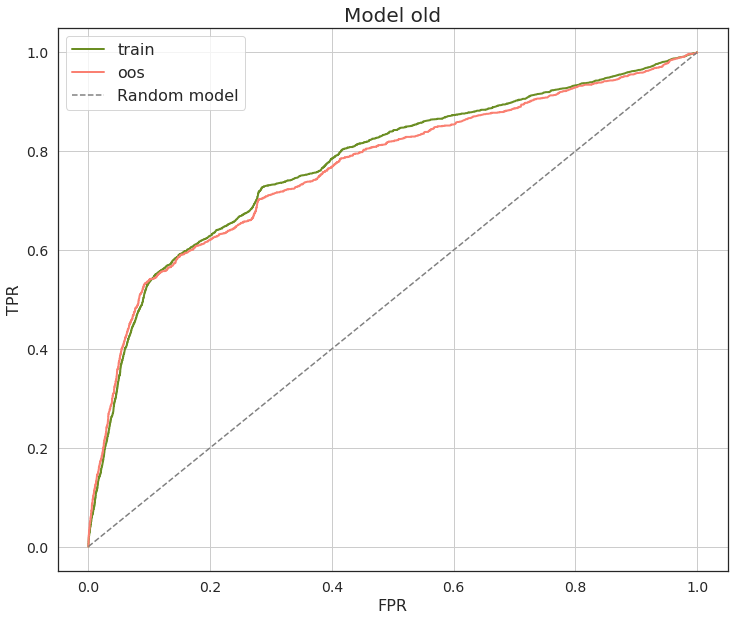

In [9]:
roc_auc_plot(model, X_train, y_train,
                X_oos, y_oos)

##### *3. Define FP and FN costs*

Define costs of communication and subscription payment.

In [10]:
e_fn = 3 #price of communication (npv-)
e_fp = 200 #price of subscription (npv+)

We want to calculate the probability of response according to communication
$$Pr_0=P(Y_i = 1| comm = 0)$$
and
$$Pr_1=P(Y_i = 1| comm = 1)$$

In [11]:
#for train
X_train_0 = X_train.copy()
X_train_0['comm'] = 0
X_train_1 = X_train.copy()
X_train_1['comm'] = 1

#for oos
X_oos_0 = X_oos.copy()
X_oos_0['comm'] = 0
X_oos_1 = X_oos.copy()
X_oos_1['comm'] = 1

Calculate the model output according to the communication input

In [12]:
X_train['pred'] = model.predict_proba(X_train)[:,1]
X_train['pred_comm0'] = model.predict_proba(X_train_0)[:,1]
X_train['pred_comm1'] = model.predict_proba(X_train_1)[:,1]


X_oos['pred'] = model.predict_proba(X_oos)[:,1]
X_oos['pred_comm0'] = model.predict_proba(X_oos_0)[:,1]
X_oos['pred_comm1'] = model.predict_proba(X_oos_1)[:,1]

Calculate the delta p $$\Delta p=Pr_1 - Pr_0$$

In [13]:
X_train['delta_p'] = X_train['pred_comm1'] - X_train['pred_comm0']
X_oos['delta_p'] = X_oos['pred_comm1'] - X_oos['pred_comm0']

Let's see the distribution of $\Delta p$

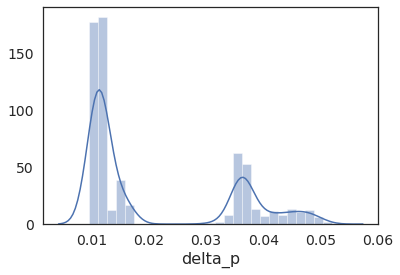

In [14]:
sns.distplot(X_train['delta_p']);

We see: 
- communication always increase the probability of response
- in most cases $\Delta p$ is small 
- we prefer to communicate with people which $\Delta p$ is bigger (communication increase their response)

In [15]:
#define threshold space to calculate the benefit
thr = np.sort(X_train['delta_p'].sample(frac = 0.01))
thr = np.hstack((thr,0.09))

**Plot benefit curve** to see the dependence between the benefit and acceptance rate

**Acceptance rate** $c$ is a percentage of observations that satisfy rule:
$$
if \Delta P \le a, i.e. c = \frac{\sum_{i=1}^{N}I\{\Delta P_i\le a\}}{N}
$$


Max(benefit_oos) = 23.35


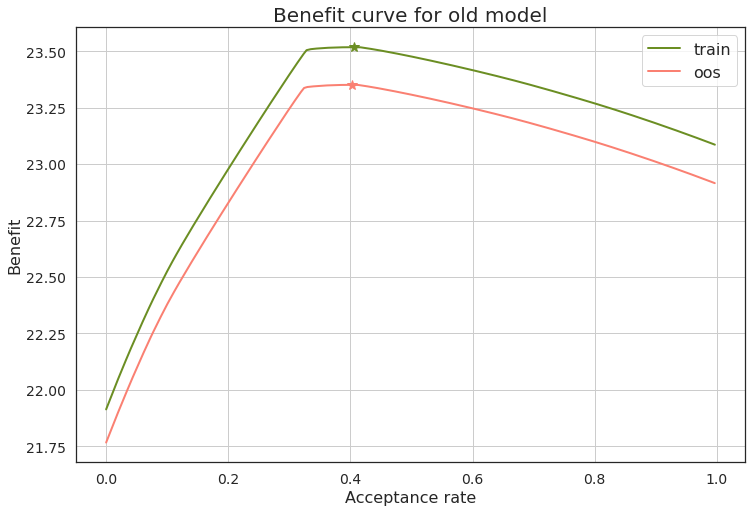

In [16]:
benefit_plot(model, X_train, y_train,
                X_oos, y_oos)

Let's see how communication increase our benefit

In [17]:
X_oos_comm1 = X_oos[X_oos.comm == 1]
y_oos_comm1 = y_oos[X_oos.comm == 1]
X_oos_comm1['target'] = y_oos_comm1

X_oos_comm0 = X_oos[X_oos.comm == 0]
y_oos_comm0 = y_oos[X_oos.comm == 0]
X_oos_comm0['target'] = y_oos_comm0

Group values according to the fact of communication and $\Delta p$

In [18]:
bins_hist = np.histogram(X_oos.delta_p, bins = 3)[1]

oos_groups_comm1 = X_oos_comm1.groupby(pd.cut(X_oos_comm1.delta_p, bins_hist))
oos_groups_comm0 = X_oos_comm0.groupby(pd.cut(X_oos_comm0.delta_p, bins_hist))
oos_groups_ = X_oos.groupby(pd.cut(X_oos.delta_p, bins_hist))

Let's see how the value
$$ \overline{Y|comm=1} - \overline{Y|comm=0} $$
and
$$\overline{Pred}$$
changes according to $\Delta p$ bin

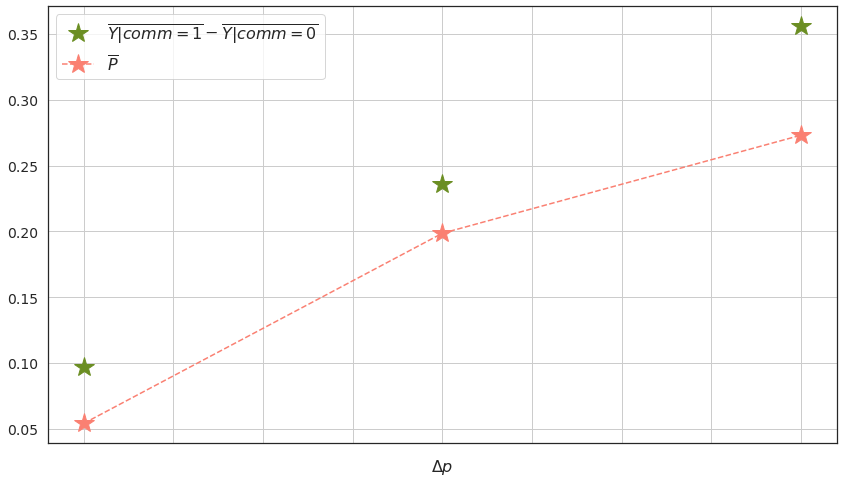

In [19]:
fig, ax1 = plt.subplots(figsize = (12,7))

Y_comm1 = oos_groups_comm1.target.mean()
Y_comm0 = oos_groups_comm0.target.mean()
delta_y = Y_comm1 - Y_comm0
(delta_y).plot(label='$\overline{Y|comm=1} - \overline{Y|comm=0}$', marker='*', 
                                    linestyle = 'None', color='olivedrab', markersize =20)


oos_groups_.pred.mean().plot(label='$\overline{P}$', marker='*', 
                                    linestyle = '--', color='salmon', markersize =20)



plt.xlabel('$\Delta p$')
plt.legend#(bbox_to_anchor=(1, 1));
plt.grid()
plt.tight_layout()

_ = plt.legend(loc= 0, prop= {'size': 16})
ax1.xaxis.set_tick_params(rotation = 60)


We see that the higher delta p the higher the probability of response. The real communication response $ \overline{Y|comm=1} - \overline{Y|comm=0} $ saves this tendention besides bin [0.0203,0.0261] where not so many observations.

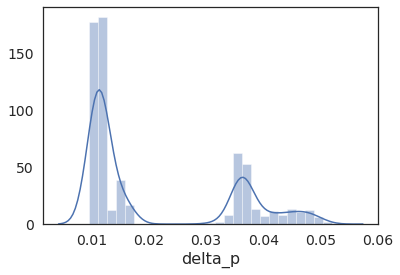

In [20]:
sns.distplot(X_train['delta_p']);

Let's see how the value
$$ \overline{Y|comm=1}$$
and
$$\overline{P_1}$$
changes according to $\Delta p$ bin

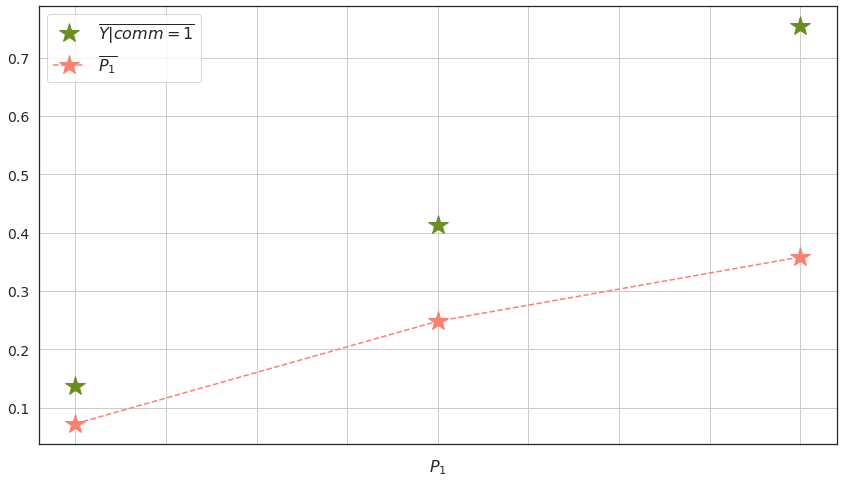

In [21]:
bins_hist = np.histogram(X_oos.pred_comm1, bins = 3)[1]

oos_groups_comm1 = X_oos_comm1.groupby(pd.cut(X_oos_comm1.pred, bins_hist))
oos_groups_ = X_oos.groupby(pd.cut(X_oos.pred, bins_hist))


fig, ax1 = plt.subplots(figsize = (12,7))

Y_comm1 = oos_groups_comm1.target.mean()


Y_comm1.plot(label='$\overline{Y|comm=1}$', marker='*', 
                                    linestyle = 'None', color='olivedrab', markersize =20)


oos_groups_.pred_comm1.mean().plot(label='$\overline{P_1}$', marker='*', 
                                    linestyle = '--', color='salmon', markersize =20)



plt.xlabel('$P_1$')
plt.legend#(bbox_to_anchor=(1, 1));
plt.grid()
plt.tight_layout()

_ = plt.legend(loc= 0, prop= {'size': 16})
ax1.xaxis.set_tick_params(rotation = 60)


Let's see how the value
$$ \overline{Y|comm=0}$$
and
$$\overline{P_0}$$
changes according to $\Delta p$ bin

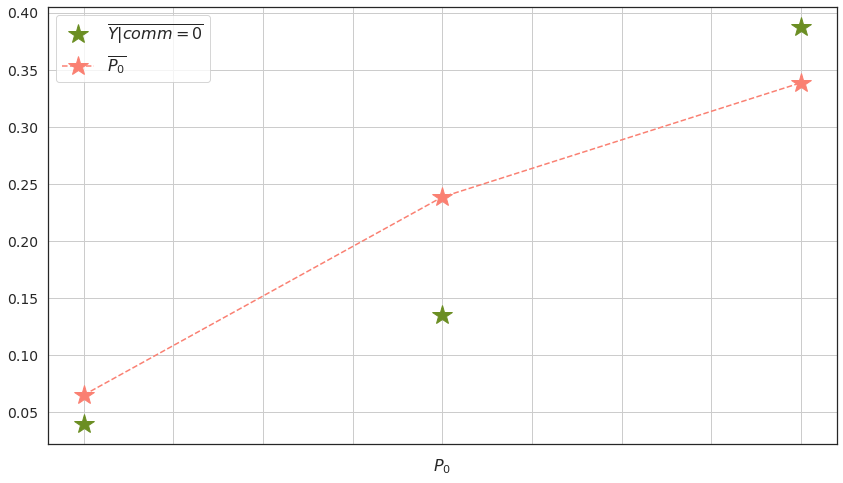

In [22]:
bins_hist = np.histogram(X_oos.pred_comm0, bins = 3)[1]

oos_groups_comm0 = X_oos_comm0.groupby(pd.cut(X_oos_comm0.pred, bins_hist))
oos_groups_ = X_oos.groupby(pd.cut(X_oos.pred, bins_hist))


fig, ax1 = plt.subplots(figsize = (12,7))

Y_comm0 = oos_groups_comm0.target.mean()


Y_comm0.plot(label='$\overline{Y|comm=0}$', marker='*', 
                                    linestyle = 'None', color='olivedrab', markersize =20)


oos_groups_.pred_comm1.mean().plot(label='$\overline{P_0}$', marker='*', 
                                    linestyle = '--', color='salmon', markersize =20)



plt.xlabel('$P_0$')
plt.legend#(bbox_to_anchor=(1, 1));
plt.grid()
plt.tight_layout()

_ = plt.legend(loc= 0, prop= {'size': 16})
ax1.xaxis.set_tick_params(rotation = 60)
